# pix2pix for Maps to Aerial Image Translation

In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import pixutils as pxu
from pix2pix import UNet, PatchGAN, fit
import wandb
import os

In [2]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
train_path = "pix2pix-maps/train/*.jpg"
val_path = "pix2pix-maps/val/*.jpg"

buffer_size = 256
patch_size = 256
num_of_patches = (600//patch_size)**2

config = {
    "batch_size": 4,
    "lr_gen": 0.0002,
    "beta_1_gen": 0.5,
    "lr_disc": 0.0002,
    "beta_1_disc": 0.5,
    "l1_lambda": 100,
}

## Run the following code block on Kaggle only

In [4]:
train_path = f"/kaggle/input/{train_path}"
val_path = f"/kaggle/input/{val_path}"

## Load dataset

In [5]:
train = tf.data.Dataset.list_files(train_path)
val = tf.data.Dataset.list_files(val_path)

In [6]:
train = train.map(pxu.load_image)
train = train.map(lambda input_image, real_image: pxu.extract_patches(input_image, real_image, patch_size, num_of_patches))
# data are in batches of size 'num_of_patches' after 'extract_patches'
train = train.unbatch()
train = train.map(lambda input_patches, real_patches: pxu.random_jitter(input_patches, real_patches, 286))
train = train.map(pxu.rescale_images)
train = train.shuffle(buffer_size)
train = train.batch(config["batch_size"])

val = val.map(pxu.load_image)
val = val.map(lambda input_image, real_image: pxu.extract_patches(input_image, real_image, patch_size, num_of_patches))
# data are in batches of size 'num_of_patches' after 'extract_patches'
val = val.unbatch()
val = val.map(pxu.rescale_images)
val = val.batch(config["batch_size"])

## Visualize a few images

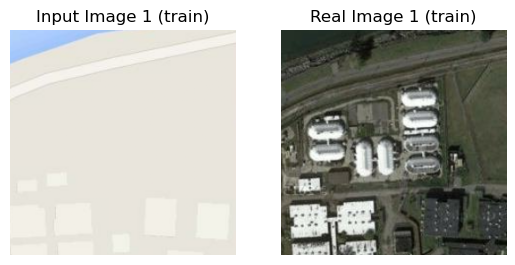

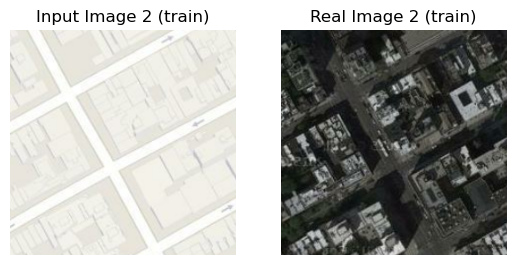

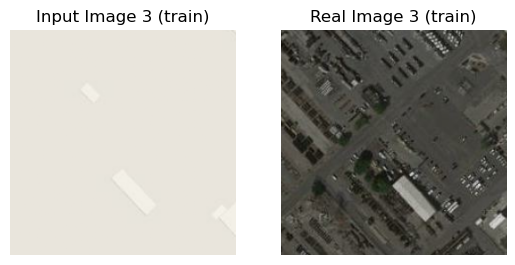

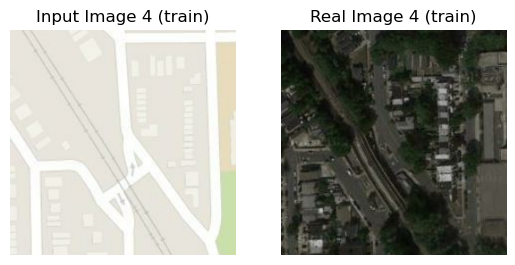

In [7]:
i = 0
for input_batch, real_batch in train.take(1):
    for input_image, real_image in zip(input_batch, real_batch):
        i += 1
        pxu.show(
            input_image,
            real_image,
            i,
            "train"
        )

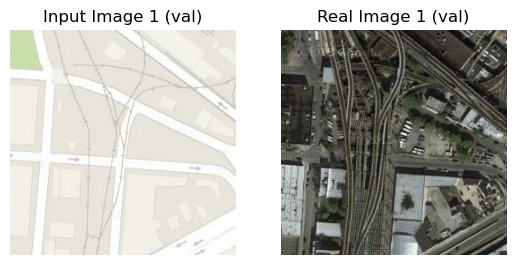

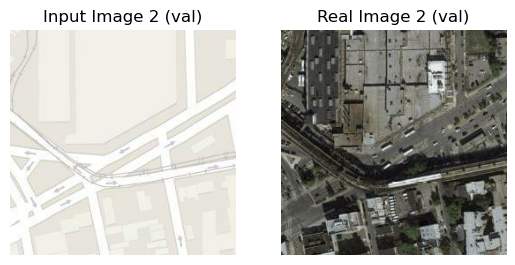

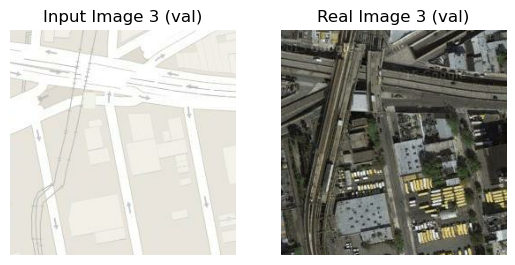

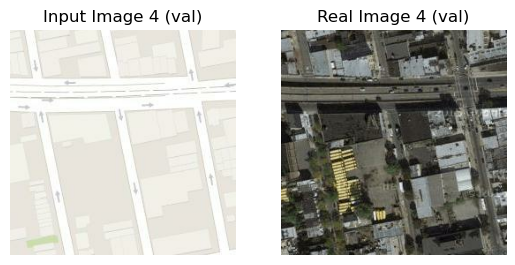

In [8]:
i = 0
for input_batch, real_batch in val.take(1):
    for input_image, real_image in zip(input_batch, real_batch):
        i += 1
        pxu.show(
            input_image,
            real_image,
            i,
            "val"
        )

## Create models

In [9]:
G = UNet(input_shape=(patch_size, patch_size, 3))
D = PatchGAN(input_shape=(patch_size, patch_size, 3))

config["epochs"] = 200

restore_last_epoch = None
restore_run_id = None

if restore_last_epoch is not None:
    config["epochs"] -= restore_last_epoch
    run_path = f"nsiete23/pix2pix/{restore_run_id}"
    gen_file = wandb.restore(f"checkpoints/generator_{restore_last_epoch}.h5", run_path=run_path)
    disc_file = wandb.restore(f"checkpoints/discriminator_{restore_last_epoch}.h5", run_path=run_path)
    G = load_model(gen_file.name)
    D = load_model(disc_file.name)
    print(
        "Resumed:",
        gen_file.name,
        disc_file.name,
        sep=os.linesep
    )

g_optim = Adam(learning_rate=config["lr_gen"], beta_1=config["beta_1_gen"])
d_optim = Adam(learning_rate=config["lr_disc"], beta_1=config["beta_1_disc"])

## Train

wandb: Currently logged in as: v-modroczky (nsiete23). Use `wandb login --relogin` to force relogin


2023-04-29 10:10:52.123376: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_8/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch: 1, Step: 1095, Gen Loss: 26.97139549255371, Disc Loss: 0.151539161801338274


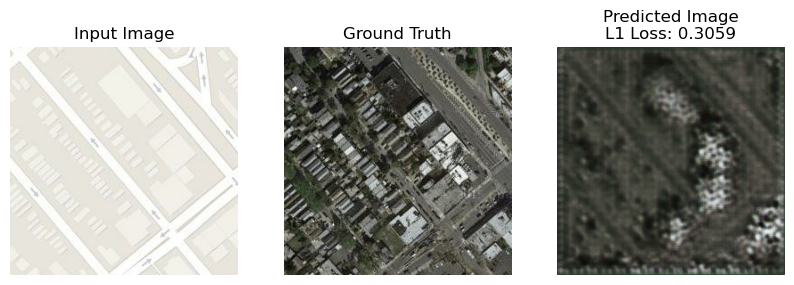

Epoch: 2, Step: 1095, Gen Loss: 27.39090919494629, Disc Loss: 0.367999970912933356
Epoch: 3, Step: 1095, Gen Loss: 30.37478256225586, Disc Loss: 1.001072764396667577
Epoch: 4, Step: 1095, Gen Loss: 30.357431411743164, Disc Loss: 0.90367293357849127
Epoch: 5, Step: 1095, Gen Loss: 23.12446403503418, Disc Loss: 0.663812458515167285
Epoch: 6, Step: 1095, Gen Loss: 18.677614212036133, Disc Loss: 0.43779981136322025
Epoch: 7, Step: 1095, Gen Loss: 13.134054183959961, Disc Loss: 1.16744303703308166
Epoch: 8, Step: 1095, Gen Loss: 27.563302993774414, Disc Loss: 0.36279898881912234
Epoch: 9, Step: 1095, Gen Loss: 25.02621841430664, Disc Loss: 2.752604246139526417
Epoch: 10, Step: 1095, Gen Loss: 24.986391067504883, Disc Loss: 0.87292945384979258


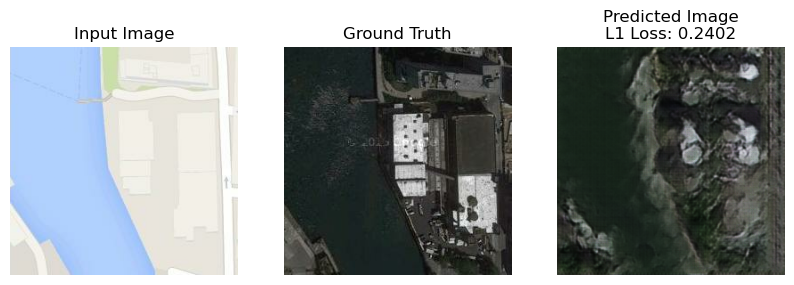

Epoch: 11, Step: 1095, Gen Loss: 28.885196685791016, Disc Loss: 0.22332543134689335
Epoch: 12, Step: 1095, Gen Loss: 31.154388427734375, Disc Loss: 0.38119658827781681
Epoch: 13, Step: 1095, Gen Loss: 26.695018768310547, Disc Loss: 1.27586102485656744
Epoch: 14, Step: 1095, Gen Loss: 22.90793800354004, Disc Loss: 1.078359842300415056
Epoch: 15, Step: 1095, Gen Loss: 32.61741256713867, Disc Loss: 0.343126118183136036
Epoch: 16, Step: 1095, Gen Loss: 19.42068099975586, Disc Loss: 1.576723337173462864
Epoch: 17, Step: 1095, Gen Loss: 22.592233657836914, Disc Loss: 0.38822668790817263
Epoch: 18, Step: 1095, Gen Loss: 26.274639129638672, Disc Loss: 0.18133839964866638
Epoch: 19, Step: 1095, Gen Loss: 31.657516479492188, Disc Loss: 0.96819150447845467
Epoch: 20, Step: 1095, Gen Loss: 21.68270492553711, Disc Loss: 1.052844762802124634


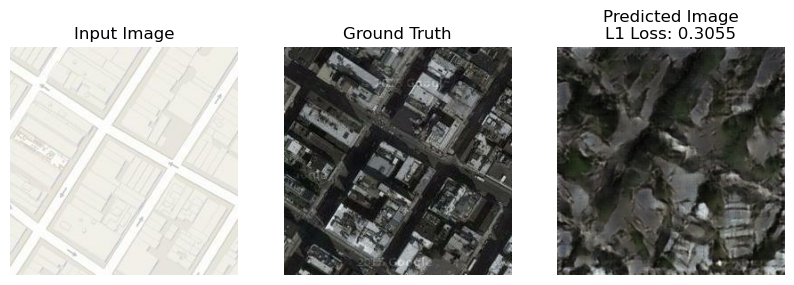

Epoch: 21, Step: 1095, Gen Loss: 20.0614070892334, Disc Loss: 1.4572622776031494528
Epoch: 22, Step: 1095, Gen Loss: 19.161266326904297, Disc Loss: 1.76409161090850836
Epoch: 23, Step: 1095, Gen Loss: 21.92068099975586, Disc Loss: 0.916556596755981452
Epoch: 24, Step: 1095, Gen Loss: 23.2672176361084, Disc Loss: 1.1477297544479375015
Epoch: 25, Step: 1095, Gen Loss: 22.6031494140625, Disc Loss: 0.3037827014923095726
Epoch: 26, Step: 1095, Gen Loss: 26.358718872070312, Disc Loss: 0.90679413080215454
Epoch: 27, Step: 1095, Gen Loss: 30.032852172851562, Disc Loss: 0.09519340097904205
Epoch: 28, Step: 1095, Gen Loss: 23.355045318603516, Disc Loss: 1.30763363838195842
Epoch: 29, Step: 1095, Gen Loss: 34.15526580810547, Disc Loss: 0.176611214876174933
Epoch: 30, Step: 1095, Gen Loss: 27.224050521850586, Disc Loss: 0.52380311489105226


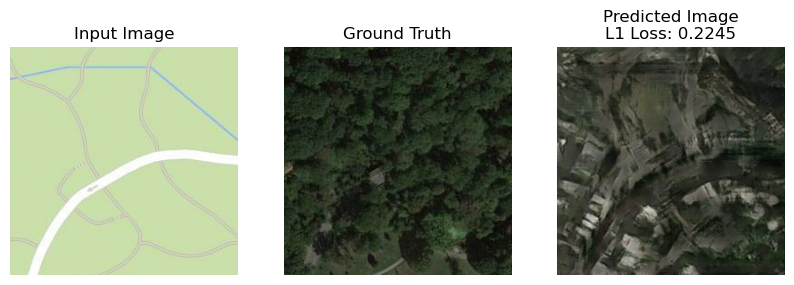

Epoch: 31, Step: 1095, Gen Loss: 14.816003799438477, Disc Loss: 1.10199975967407233
Epoch: 32, Step: 1095, Gen Loss: 25.719327926635742, Disc Loss: 1.28074347972869874
Epoch: 33, Step: 1095, Gen Loss: 20.416784286499023, Disc Loss: 0.70809298753738486
Epoch: 34, Step: 1095, Gen Loss: 29.791166305541992, Disc Loss: 0.12342254817485814
Epoch: 35, Step: 1095, Gen Loss: 28.456392288208008, Disc Loss: 0.59345400333404545
Epoch: 36, Step: 1095, Gen Loss: 24.245214462280273, Disc Loss: 1.22057700157165534
Epoch: 37, Step: 1095, Gen Loss: 24.07355499267578, Disc Loss: 0.331270903348922735
Epoch: 38, Step: 1095, Gen Loss: 24.081701278686523, Disc Loss: 0.44212350249290466
Epoch: 39, Step: 1095, Gen Loss: 16.22715187072754, Disc Loss: 0.8321657180786133476
Epoch: 40, Step: 1095, Gen Loss: 33.21930694580078, Disc Loss: 0.517054796218872153


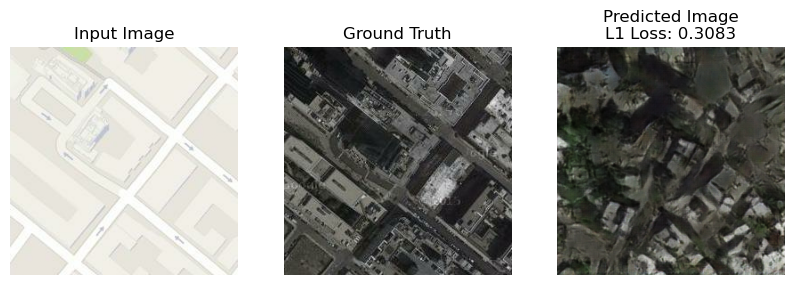

Epoch: 41, Step: 1095, Gen Loss: 21.755895614624023, Disc Loss: 1.686107635498046964
Epoch: 42, Step: 1095, Gen Loss: 23.9897518157959, Disc Loss: 0.7065734267234802677
Epoch: 43, Step: 1095, Gen Loss: 23.87689208984375, Disc Loss: 0.439633309841156067
Epoch: 44, Step: 1095, Gen Loss: 26.20290756225586, Disc Loss: 0.839003264904022244
Epoch: 45, Step: 1095, Gen Loss: 27.85093879699707, Disc Loss: 1.095639824867248556
Epoch: 46, Step: 1095, Gen Loss: 29.143943786621094, Disc Loss: 0.58117967844009475
Epoch: 47, Step: 1095, Gen Loss: 30.028850555419922, Disc Loss: 0.31213757395744324
Epoch: 48, Step: 1095, Gen Loss: 33.25156784057617, Disc Loss: 0.677605986595153893
Epoch: 49, Step: 1095, Gen Loss: 21.222131729125977, Disc Loss: 1.08431029319763187
Epoch: 50, Step: 1095, Gen Loss: 30.524860382080078, Disc Loss: 2.65881204605102544


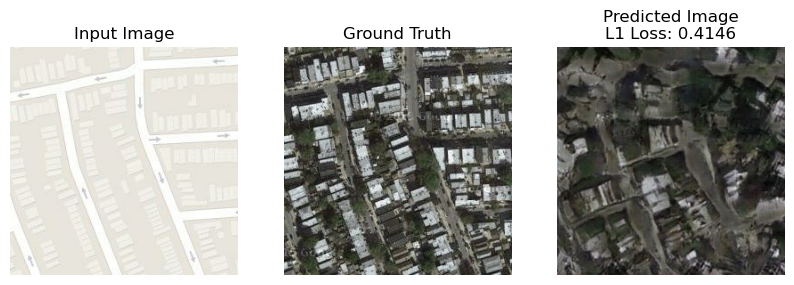

Epoch: 51, Step: 1095, Gen Loss: 23.103681564331055, Disc Loss: 1.18957698345184334
Epoch: 52, Step: 1095, Gen Loss: 19.912630081176758, Disc Loss: 0.241050288081169135
Epoch: 53, Step: 1095, Gen Loss: 26.009035110473633, Disc Loss: 0.72239559888839723
Epoch: 54, Step: 1095, Gen Loss: 30.60713005065918, Disc Loss: 0.047520440071821216
Epoch: 55, Step: 1095, Gen Loss: 30.091806411743164, Disc Loss: 0.39947587251663217
Epoch: 56, Step: 1095, Gen Loss: 18.74265480041504, Disc Loss: 0.200020179152488771
Epoch: 57, Step: 1095, Gen Loss: 33.385955810546875, Disc Loss: 0.266393214464187644
Epoch: 58, Step: 1095, Gen Loss: 26.03510284423828, Disc Loss: 1.069470047950744693
Epoch: 59, Step: 1095, Gen Loss: 24.413475036621094, Disc Loss: 2.19910717010498056
Epoch: 60, Step: 1095, Gen Loss: 29.092674255371094, Disc Loss: 0.86964243650436425


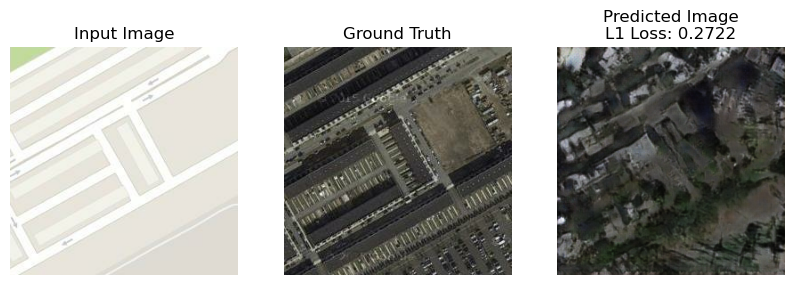

Epoch: 61, Step: 1095, Gen Loss: 25.457759857177734, Disc Loss: 0.322419643402099675
Epoch: 62, Step: 1095, Gen Loss: 18.452959060668945, Disc Loss: 1.50939249992370666
Epoch: 63, Step: 1095, Gen Loss: 23.873205184936523, Disc Loss: 0.90934532880783086
Epoch: 64, Step: 1095, Gen Loss: 26.95815086364746, Disc Loss: 1.196406006813049338
Epoch: 65, Step: 1095, Gen Loss: 25.45762062072754, Disc Loss: 0.460764408111572278
Epoch: 66, Step: 1095, Gen Loss: 31.97724723815918, Disc Loss: 0.106783747673034676
Epoch: 67, Step: 1095, Gen Loss: 24.532899856567383, Disc Loss: 0.90995365381240846
Epoch: 68, Step: 1095, Gen Loss: 25.092716217041016, Disc Loss: 1.20511209964752254
Epoch: 69, Step: 1095, Gen Loss: 18.52616310119629, Disc Loss: 1.771228551864624585
Epoch: 70, Step: 1095, Gen Loss: 16.555355072021484, Disc Loss: 0.31345102190971375


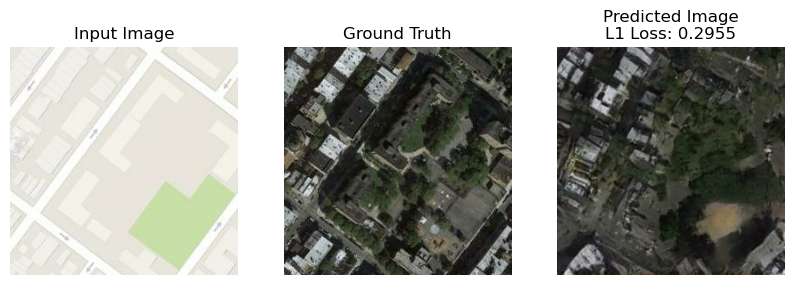

Epoch: 71, Step: 1095, Gen Loss: 27.957584381103516, Disc Loss: 0.56329113245010385
Epoch: 72, Step: 1095, Gen Loss: 28.757381439208984, Disc Loss: 0.86689078807830816
Epoch: 73, Step: 1095, Gen Loss: 31.094491958618164, Disc Loss: 0.322796463966369636
Epoch: 74, Step: 1095, Gen Loss: 35.419090270996094, Disc Loss: 0.07306871563196182
Epoch: 75, Step: 1095, Gen Loss: 29.32509994506836, Disc Loss: 0.599141001701355943
Epoch: 76, Step: 1095, Gen Loss: 30.42173194885254, Disc Loss: 0.821003794670105197
Epoch: 77, Step: 1095, Gen Loss: 29.168588638305664, Disc Loss: 0.68950581550598147
Epoch: 78, Step: 1095, Gen Loss: 29.95401382446289, Disc Loss: 0.254368424415588444
Epoch: 79, Step: 1095, Gen Loss: 26.78253173828125, Disc Loss: 0.587421953678131125
Epoch: 80, Step: 1095, Gen Loss: 25.313129425048828, Disc Loss: 0.12705972790718088


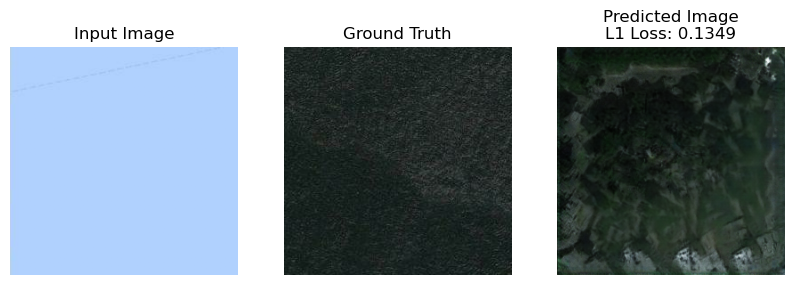

Epoch: 81, Step: 1095, Gen Loss: 21.282005310058594, Disc Loss: 0.15656018257141113
Epoch: 82, Step: 1095, Gen Loss: 28.429039001464844, Disc Loss: 0.41194820404052734
Epoch: 83, Step: 1095, Gen Loss: 25.368989944458008, Disc Loss: 0.26388296484947205
Epoch: 84, Step: 1095, Gen Loss: 34.58485794067383, Disc Loss: 0.152721181511878977
Epoch: 85, Step: 1095, Gen Loss: 34.08418655395508, Disc Loss: 0.3364942967891693446
Epoch: 86, Step: 1095, Gen Loss: 24.56797218322754, Disc Loss: 0.6744139194488525875
Epoch: 87, Step: 1095, Gen Loss: 28.707996368408203, Disc Loss: 0.60766834020614623
Epoch: 88, Step: 1095, Gen Loss: 27.619901657104492, Disc Loss: 0.32682234048843384
Epoch: 89, Step: 1095, Gen Loss: 22.08770179748535, Disc Loss: 0.2796133756637573452
Epoch: 90, Step: 1095, Gen Loss: 21.752639770507812, Disc Loss: 0.27019962668418884


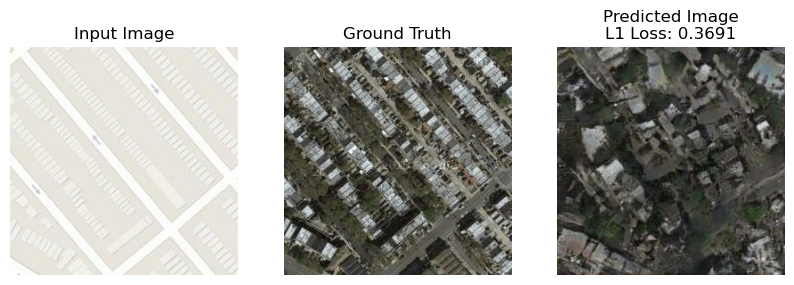

Epoch: 91, Step: 1095, Gen Loss: 26.34957504272461, Disc Loss: 0.3585622310638428393
Epoch: 92, Step: 1095, Gen Loss: 26.568330764770508, Disc Loss: 0.375452250242233376
Epoch: 93, Step: 1095, Gen Loss: 25.862918853759766, Disc Loss: 0.22441533207893372
Epoch: 94, Step: 1095, Gen Loss: 28.27165412902832, Disc Loss: 0.520123362541198734
Epoch: 95, Step: 1095, Gen Loss: 23.92818832397461, Disc Loss: 0.321022033691406253
Epoch: 96, Step: 1095, Gen Loss: 21.306751251220703, Disc Loss: 0.612155437469482414
Epoch: 97, Step: 1095, Gen Loss: 24.058868408203125, Disc Loss: 0.34169352054595955
Epoch: 98, Step: 1095, Gen Loss: 30.23231315612793, Disc Loss: 0.221001118421554574
Epoch: 99, Step: 1095, Gen Loss: 31.30510711669922, Disc Loss: 0.545428216457366987
Epoch: 100, Step: 1095, Gen Loss: 28.534198760986328, Disc Loss: 0.27073466777801514


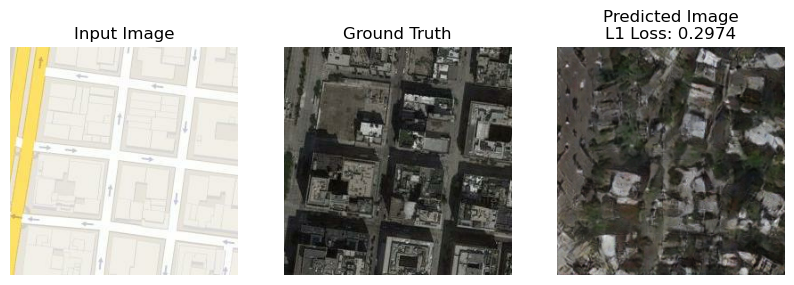

Epoch: 101, Step: 1095, Gen Loss: 16.391130447387695, Disc Loss: 0.65866577625274665
Epoch: 102, Step: 1095, Gen Loss: 26.900489807128906, Disc Loss: 0.28958719968795776
Epoch: 103, Step: 1095, Gen Loss: 20.66720199584961, Disc Loss: 0.565923333168029808
Epoch: 104, Step: 1095, Gen Loss: 26.54698944091797, Disc Loss: 0.7264195680618286686
Epoch: 105, Step: 1095, Gen Loss: 29.217878341674805, Disc Loss: 1.15823721885681155
Epoch: 106, Step: 1095, Gen Loss: 33.39414978027344, Disc Loss: 0.098546370863914497
Epoch: 107, Step: 1095, Gen Loss: 29.700389862060547, Disc Loss: 0.44823461771011357
Epoch: 108, Step: 1095, Gen Loss: 26.57537269592285, Disc Loss: 0.6134486794471741906
Epoch: 109, Step: 1095, Gen Loss: 22.75293731689453, Disc Loss: 0.682606041431427558
Epoch: 110, Step: 1095, Gen Loss: 19.587566375732422, Disc Loss: 0.40733078122138977


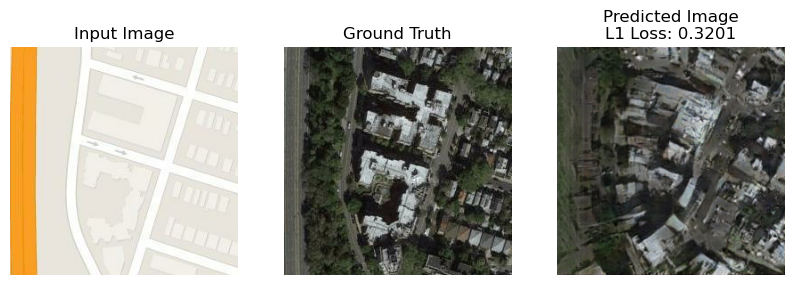

Epoch: 111, Step: 1095, Gen Loss: 23.0327205657959, Disc Loss: 1.2561582326889038462
Epoch: 112, Step: 1095, Gen Loss: 24.62793731689453, Disc Loss: 0.329299390316009516
Epoch: 113, Step: 1095, Gen Loss: 25.79096031188965, Disc Loss: 0.436584234237670993
Epoch: 114, Step: 1095, Gen Loss: 27.103479385375977, Disc Loss: 0.528202474117279784
Epoch: 115, Step: 1095, Gen Loss: 29.639604568481445, Disc Loss: 0.50436031818389893
Epoch: 116, Step: 1095, Gen Loss: 16.68229103088379, Disc Loss: 0.783616185188293556
Epoch: 117, Step: 1095, Gen Loss: 18.342222213745117, Disc Loss: 0.18873256444931034
Epoch: 118, Step: 1095, Gen Loss: 25.671052932739258, Disc Loss: 1.55104315280914372
Epoch: 119, Step: 1095, Gen Loss: 24.717409133911133, Disc Loss: 0.38801693916320896
Epoch: 120, Step: 1095, Gen Loss: 24.829195022583008, Disc Loss: 0.28611913323402405


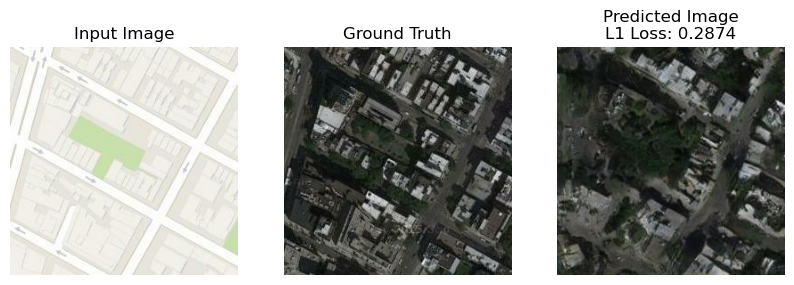

Epoch: 121, Step: 1095, Gen Loss: 18.75017738342285, Disc Loss: 0.224934220314025883
Epoch: 122, Step: 1095, Gen Loss: 17.63015365600586, Disc Loss: 1.320137500762939513
Epoch: 123, Step: 1095, Gen Loss: 22.610525131225586, Disc Loss: 0.26285794377326965
Epoch: 124, Step: 1095, Gen Loss: 18.841190338134766, Disc Loss: 0.77229827642440894
Epoch: 125, Step: 1095, Gen Loss: 21.036863327026367, Disc Loss: 1.08867454528808644
Epoch: 126, Step: 1095, Gen Loss: 24.04705810546875, Disc Loss: 0.354522019624710167
Epoch: 127, Step: 1095, Gen Loss: 21.807470321655273, Disc Loss: 0.46078523993492126
Epoch: 128, Step: 1095, Gen Loss: 23.740468978881836, Disc Loss: 0.50624078512191775
Epoch: 129, Step: 1095, Gen Loss: 35.67183303833008, Disc Loss: 0.081165760755538942
Epoch: 130, Step: 1095, Gen Loss: 21.023956298828125, Disc Loss: 1.11333835124969486


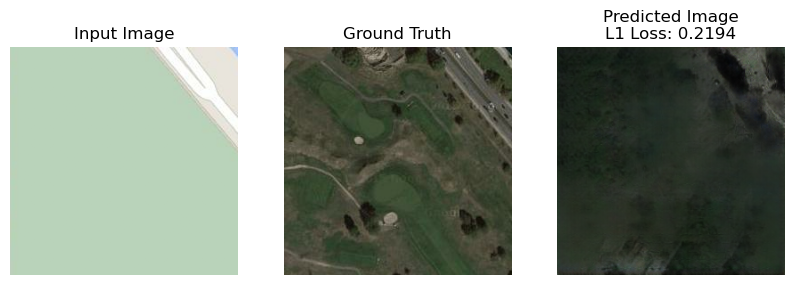

Epoch: 131, Step: 1095, Gen Loss: 25.687572479248047, Disc Loss: 1.23048448562622071
Epoch: 132, Step: 1095, Gen Loss: 19.716962814331055, Disc Loss: 0.62057340145111083
Epoch: 133, Step: 1095, Gen Loss: 23.997655868530273, Disc Loss: 0.65458661317825326
Epoch: 134, Step: 1095, Gen Loss: 21.780071258544922, Disc Loss: 0.86991196870803832
Epoch: 135, Step: 1095, Gen Loss: 30.045595169067383, Disc Loss: 0.20609733462333687
Epoch: 136, Step: 1095, Gen Loss: 28.27168083190918, Disc Loss: 1.256241202354431247
Epoch: 137, Step: 1095, Gen Loss: 20.584383010864258, Disc Loss: 0.21988829970359802
Epoch: 138, Step: 1095, Gen Loss: 27.704593658447266, Disc Loss: 1.11551368236541752
Epoch: 139, Step: 1095, Gen Loss: 21.36969757080078, Disc Loss: 0.7257562875747681677
Epoch: 140, Step: 1095, Gen Loss: 20.696861267089844, Disc Loss: 1.23917043209075932


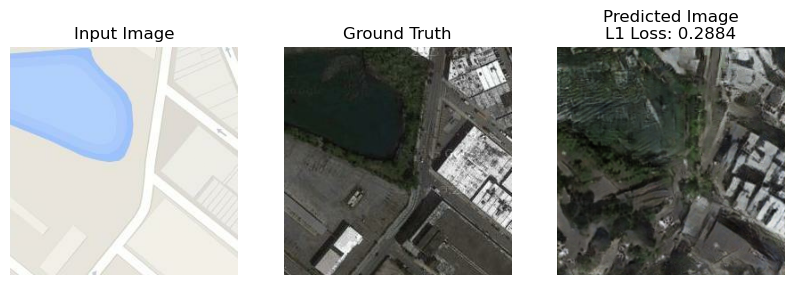

Epoch: 141, Step: 1095, Gen Loss: 19.283220291137695, Disc Loss: 0.46605634689331055
Epoch: 142, Step: 1095, Gen Loss: 11.137006759643555, Disc Loss: 2.73533558845529443
Epoch: 143, Step: 1095, Gen Loss: 20.621801376342773, Disc Loss: 0.601164996623992943
Epoch: 144, Step: 1095, Gen Loss: 32.35076141357422, Disc Loss: 0.126959010958671575
Epoch: 145, Step: 1095, Gen Loss: 27.75462532043457, Disc Loss: 1.170422196388244633
Epoch: 146, Step: 1095, Gen Loss: 31.648189544677734, Disc Loss: 0.71040821075439457
Epoch: 147, Step: 1095, Gen Loss: 32.821170806884766, Disc Loss: 0.03392615541815758
Epoch: 148, Step: 1095, Gen Loss: 18.536943435668945, Disc Loss: 0.88934767246246345
Epoch: 149, Step: 1095, Gen Loss: 30.98501968383789, Disc Loss: 0.162610933184623724
Epoch: 150, Step: 1095, Gen Loss: 24.708171844482422, Disc Loss: 0.275725960731506357


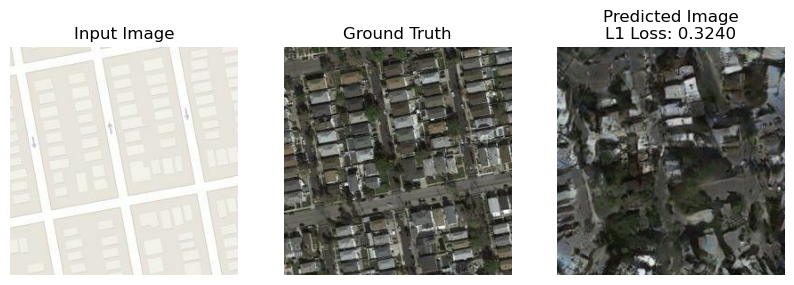

Epoch: 151, Step: 1095, Gen Loss: 26.30176544189453, Disc Loss: 0.437883734703063964
Epoch: 152, Step: 1095, Gen Loss: 21.15445899963379, Disc Loss: 0.252688467502594364
Epoch: 153, Step: 1095, Gen Loss: 31.300100326538086, Disc Loss: 0.19926549494266515
Epoch: 154, Step: 1095, Gen Loss: 20.60536003112793, Disc Loss: 0.690041661262512268
Epoch: 155, Step: 1095, Gen Loss: 24.70086097717285, Disc Loss: 1.209096670150756826
Epoch: 156, Step: 1095, Gen Loss: 27.363630294799805, Disc Loss: 0.49874937534332275
Epoch: 157, Step: 1095, Gen Loss: 26.03380012512207, Disc Loss: 0.641817688941955616
Epoch: 158, Step: 1095, Gen Loss: 24.390668869018555, Disc Loss: 0.53358006477355966
Epoch: 159, Step: 1095, Gen Loss: 23.708572387695312, Disc Loss: 0.443239569664001466
Epoch: 160, Step: 1095, Gen Loss: 26.230560302734375, Disc Loss: 0.53422212600708014


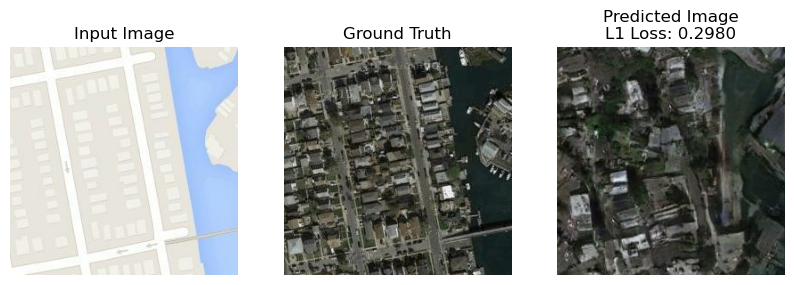

Epoch: 161, Step: 1095, Gen Loss: 31.689172744750977, Disc Loss: 0.046097740530967714
Epoch: 162, Step: 1095, Gen Loss: 29.236608505249023, Disc Loss: 0.85285866260528567
Epoch: 163, Step: 1095, Gen Loss: 24.248472213745117, Disc Loss: 0.655490636825561585
Epoch: 164, Step: 1095, Gen Loss: 27.69021224975586, Disc Loss: 0.323891878128051764
Epoch: 165, Step: 1095, Gen Loss: 34.41836166381836, Disc Loss: 0.100274056196212773
Epoch: 166, Step: 1095, Gen Loss: 24.361202239990234, Disc Loss: 0.11760894954204565
Epoch: 167, Step: 1095, Gen Loss: 26.6369571685791, Disc Loss: 0.4954903721809387623
Epoch: 168, Step: 1095, Gen Loss: 23.847978591918945, Disc Loss: 0.147389248013496444
Epoch: 169, Step: 1095, Gen Loss: 25.538402557373047, Disc Loss: 0.30006027221679695
Epoch: 170, Step: 1095, Gen Loss: 28.022052764892578, Disc Loss: 0.38086789846420296


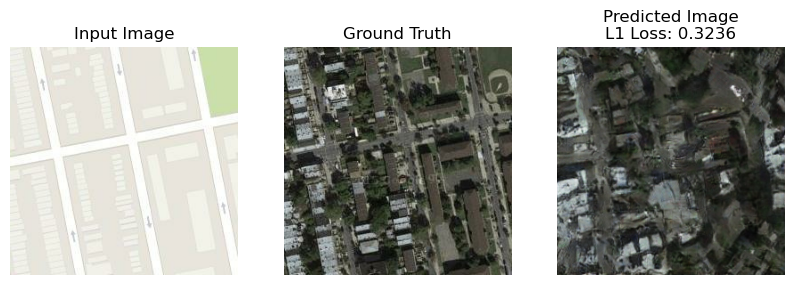

Epoch: 171, Step: 1095, Gen Loss: 29.55572509765625, Disc Loss: 0.122739538550376897
Epoch: 172, Step: 1095, Gen Loss: 34.053707122802734, Disc Loss: 0.121433123946189884
Epoch: 173, Step: 1095, Gen Loss: 23.245420455932617, Disc Loss: 1.32938110828399667
Epoch: 174, Step: 1095, Gen Loss: 27.990732192993164, Disc Loss: 0.45140799880027775
Epoch: 175, Step: 1095, Gen Loss: 28.705062866210938, Disc Loss: 0.359541475772857674
Epoch: 176, Step: 1095, Gen Loss: 26.07231903076172, Disc Loss: 0.8952249884605408644
Epoch: 177, Step: 1095, Gen Loss: 31.888351440429688, Disc Loss: 0.05046790838241577
Epoch: 178, Step: 1095, Gen Loss: 18.405075073242188, Disc Loss: 0.56321841478347784
Epoch: 179, Step: 1095, Gen Loss: 29.95575714111328, Disc Loss: 0.402108758687973245
Epoch: 180, Step: 1095, Gen Loss: 29.00168228149414, Disc Loss: 0.201613411307334943


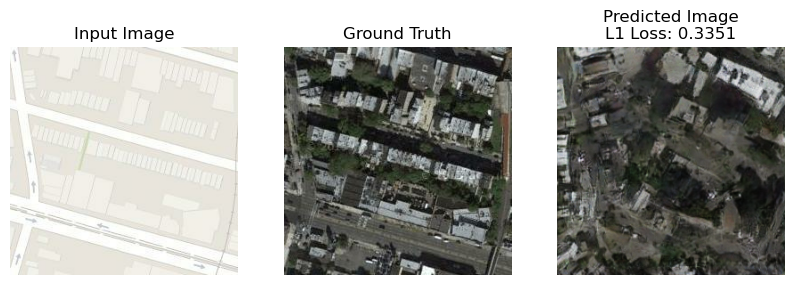

Epoch: 181, Step: 1095, Gen Loss: 31.022979736328125, Disc Loss: 0.15651647746562958
Epoch: 182, Step: 1095, Gen Loss: 23.294879913330078, Disc Loss: 0.524916231632232736
Epoch: 183, Step: 1095, Gen Loss: 27.879653930664062, Disc Loss: 0.36008563637733467
Epoch: 184, Step: 1095, Gen Loss: 29.868839263916016, Disc Loss: 0.57841014862060553
Epoch: 185, Step: 1095, Gen Loss: 29.752031326293945, Disc Loss: 0.18934929370880127
Epoch: 186, Step: 1095, Gen Loss: 27.03034782409668, Disc Loss: 0.510735988616943424
Epoch: 187, Step: 1095, Gen Loss: 25.369455337524414, Disc Loss: 0.30258911848068247
Epoch: 188, Step: 1095, Gen Loss: 23.498550415039062, Disc Loss: 0.797802507877349953
Epoch: 189, Step: 1095, Gen Loss: 28.20758056640625, Disc Loss: 0.1859197616577148456
Epoch: 190, Step: 1095, Gen Loss: 30.40603256225586, Disc Loss: 0.283627659082412723


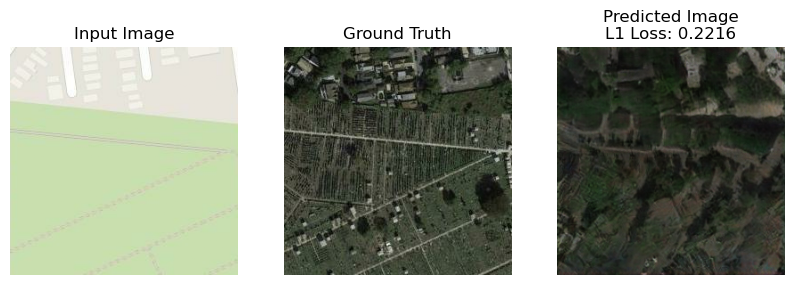

Epoch: 191, Step: 1095, Gen Loss: 26.24456787109375, Disc Loss: 0.177468553185462955
Epoch: 192, Step: 1095, Gen Loss: 31.052043914794922, Disc Loss: 0.21007439494132996
Epoch: 193, Step: 1095, Gen Loss: 28.659446716308594, Disc Loss: 0.141110092401504522
Epoch: 194, Step: 1095, Gen Loss: 26.280893325805664, Disc Loss: 0.38004806637763977
Epoch: 195, Step: 1095, Gen Loss: 28.689455032348633, Disc Loss: 0.88872694969177259
Epoch: 196, Step: 1095, Gen Loss: 34.205223083496094, Disc Loss: 0.23624795675277714
Epoch: 197, Step: 1095, Gen Loss: 20.622522354125977, Disc Loss: 0.52560025453567525
Epoch: 198, Step: 1095, Gen Loss: 22.467113494873047, Disc Loss: 0.436803191900253356
Epoch: 199, Step: 1095, Gen Loss: 29.52640724182129, Disc Loss: 0.254104703664779666
Epoch: 200, Step: 1095, Gen Loss: 24.581924438476562, Disc Loss: 0.26157644391059875


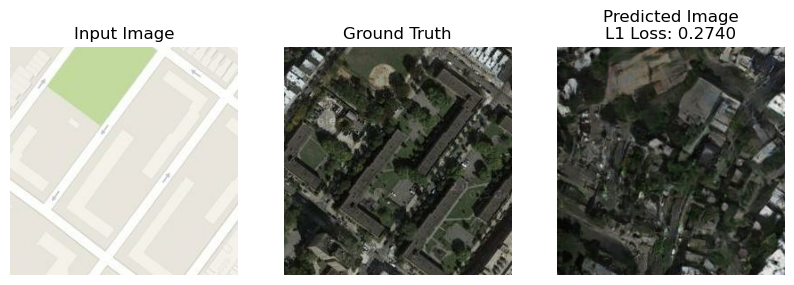

In [10]:
run = wandb.init(config=config, project="pix2pix")

fit(
    train_data=train,
    val_data=val,
    epochs=config["epochs"],
    generator=G,
    discriminator=D,
    generator_optimizer=g_optim,
    discriminator_optimizer=d_optim,
    l1_lambda=config["l1_lambda"],
)

In [11]:
wandb.finish()